In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import packages
import math
import numpy as np
import pylab as py

import matplotlib.pyplot as plt

from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

from nbody6tools import Reader
from nbody62spisea import converter

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [3]:
# Cluster parameters: 0.1 g/m^3, age = 5 Myr
# Independent variable: e_ff
# Dependent variable: Sum of squares defined by sampled star vs model star on oldest isochrone

e_ff_Arr = ['001', '003', '010', '030', '100']
nbody_path_stub = '/storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff'

In [4]:
# isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F200W']
filters = ['m_jwst_F115W', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

In [20]:
def plot_iso_grid(iso_grid, log_age_arr, level_age_arr, filters):
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(iso_grid[i].points[filters[0]] - iso_grid[i].points[filters[1]], 
            iso_grid[i].points[filters[1]], color=color, label='')
        
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()

    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (millions of years)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

In [55]:
# Compute spread process:
    # Sample 30 random stars from population at random
    # Compute sum of squares of distance in color-magnitude space
        # Sum of squares computed using sampled stars as "observations"
    # Repeat for another 30 samples
    # Print average sum of squares
    # Do this for every e_ff
    
# Data needed for computation:
    # isochrone grid
    # age of oldest isochrone
    # stars' properties, with accompanying age and mass
    
import random
    
def sample_pop(stars):
    starSample = []
    
    i = 0
    while i < 30:
        idxRand = random.randint(0, len(stars))
        if (stars[idxRand] is not None):
            starSample.append(stars[i])
            i = i + 1
    return starSample
    
def compute_spread():
    

TypeError: compute_spread() takes 1 positional argument but 2 were given

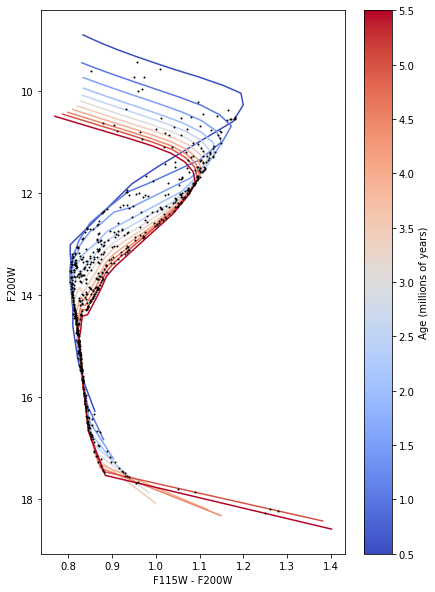

In [56]:
nbody_path = nbody_path_stub + '001_00/'
snapshot = Reader.read_snapshot(nbody_path, time = 5)
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6
log_ages = np.log10(level_ages)

first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
        
compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
        
increment = 0.5e6

if min(level_ages) < 0.5e6:
    start = 0.5e6
else:
    start = (min(level_ages) // increment) * increment

end = (max(level_ages) // increment) * increment + 2 * increment

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
    
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/cmd_generator')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
fig, axes = py.subplots(figsize=(15, 10))

py.subplot(1, 2, 1)
plot_iso_grid(instances, log_age_arr, level_age_arr, filters)

for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
# calculate spread of stars
compute_spread(stars, masses, log_age_arr, instances)
    